# Analisis exploratorio de datos (EDA) y preprocesamiento 

In [477]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

def boxplotAndHist(na, binwidth=0.5):
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # assigning a graph to each ax
    sns.boxplot(na, orient="h", ax=ax_box)
    sns.histplot(na, binwidth=binwidth, ax=ax_hist)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()



## Análisis univariable

### Análisis de tipos

In [478]:
dic = {
    "Precio": [1, 13, "16", 25.2, np.nan, 32],
    "Size": ["Grande", "Mediano", "Peque", "Grande", "Peque", "Grande"],
    "Titulo":["-", "Dr", "Sr", "Ing", "+", "n"],
    "Color": ["Rojo", "Verde", "Verde", "Verde", "Verde", "Rojo"],
    "Costo":[15,15,15,15,15,15],
    "target":["Tipo1", "Tipo2", "Tipo1", "Tipo2", "Tipo1", "Tipo2"]
}

df = pd.DataFrame(dic)

Observar los tipos. Son object. En la primera columna es claro, dado que la misma esta muy poco formalizada. Sera conveniente trabajar con flotantes ya que la naturaleza del dato es flotante, se ganara en eficiencia general. En la segunda columna es una cadena puede almacenarse como object o la solución recomandada es usar StringDtype. ¿Por que? Porque object puede almacenar cualquier cosa, con StringDtype nos aseguramos cadenas. 

In [479]:
df.dtypes

Precio    object
Size      object
Titulo    object
Color     object
Costo      int64
target    object
dtype: object

Convertimos

In [480]:
df["Precio"] = df["Precio"].astype("float")
df.dtypes

Precio    float64
Size       object
Titulo     object
Color      object
Costo       int64
target     object
dtype: object

In [481]:
df["Size"] = df["Size"].astype("string")
df["Titulo"] = df["Titulo"].astype("string")
df["Color"] = df["Color"].astype("string")
#o
df["Size"] = df["Size"].astype(dtype=pd.StringDtype())

In [482]:
df.dtypes

Precio           float64
Size      string[python]
Titulo    string[python]
Color     string[python]
Costo              int64
target            object
dtype: object

Los tipos incorrectos aumentan la carga de procesamiento ¿Porque no normalizarlos?

In [483]:
vals = np.random.randint(0, 10, 10000000)    
ovals = vals.astype("object")
print(vals.dtype, ovals.dtype)


int32 object


In [484]:
%timeit vals/4 

71.7 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [485]:
%timeit ovals/4

699 ms ± 182 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Los tiempos son mucho mas rápidos cuando utilizo el tipo de dato que corresponde, incluso puede llegar a utilizar optimizaciones de hardware  (SIMD, Single Instruction, Multiple Data).

### Datos categóricos

¿Que datos categóricos y que datos numericos tengo? ¿Los categóricos son ordinales?

¿Cuantos categoricos tengo en columna categórica?

In [486]:
df["Size"].unique()

<StringArray>
['Grande', 'Mediano', 'Peque']
Length: 3, dtype: string

La categorica ordinal deberia pasarse a número...hay varias opciones disponibles

Mediante map...

In [487]:
df["Size_ordinal_map"] = df["Size"].map({"Peque": 0, "Mediano": 1, "Grande": 2})

Mediante ordinal encoder...

In [488]:
oe = OrdinalEncoder(categories=[["Peque", "Mediano", "Grande"]])
oe.fit(df[["Size"]])
df.loc[:, "Size_ordinalEncoder"] = oe.transform(df[["Size"]]).astype("int")
df.loc[:, ["Size", "Size_ordinalEncoder"]]

,Size,Size_ordinalEncoder
0,Grande,2
1,Mediano,1
2,Peque,0
3,Grande,2
4,Peque,0
5,Grande,2


⚠️Cuidado!! estoy siempre agregando columnas con fines didácticos, para poder ver como se transforman, en la realidad deberiamos eliminar la columna transformada ya que es redundante.

Transformación inversa.

In [489]:
oe.inverse_transform(df[["Size_ordinalEncoder"]])

array([['Grande'],
       ['Mediano'],
       ['Peque'],
       ['Grande'],
       ['Peque'],
       ['Grande']], dtype=object)

Para target, usamos label encoder.

In [490]:
le = LabelEncoder()
le.fit(df["target"])
le.transform(df["target"])  

array([0, 1, 0, 1, 0, 1])

In [491]:
le.inverse_transform(le.transform(df["target"]))

array(['Tipo1', 'Tipo2', 'Tipo1', 'Tipo2', 'Tipo1', 'Tipo2'], dtype=object)

¿Cuantos categoricos (porcentaje) tengo en columna texto?

In [492]:
len(df["Titulo"].unique())/len(df)

1.0

¿Cuantos categoricos tengo en columna CatNoOrdinal?


In [493]:
df["Color"]

0     Rojo
1    Verde
2    Verde
3    Verde
4    Verde
5     Rojo
Name: Color, dtype: string

La categorica no ordinal no debería tener un orden, para algunos algoritmos el numero puede ser tomado como una magnitud.

In [494]:
len(df["Color"].unique())

2

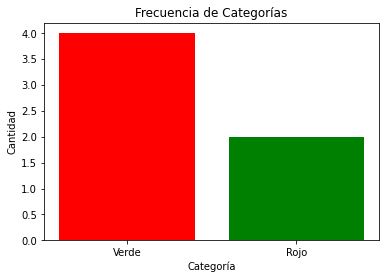

In [495]:
cateries = df["Color"].value_counts()
plt.bar(cateries.index, cateries.values, color=['red', 'green'])
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.title('Frecuencia de Categorías')
plt.show()

Esto debería transformarse utilizando "one-hot", las opciones son varias, desde usar directamente pandas o utilizar sklearn (interface consistente)

In [496]:
pd.get_dummies(df["Color"])

,Rojo,Verde
0,True,False
1,False,True
2,False,True
3,False,True
4,False,True
5,True,False


In [497]:
oh = OneHotEncoder(sparse_output=False)#drop="first"
oh.fit(df[["Color"]])
oh.transform(df[["Color"]])

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

Varios problemas acá, me retorna 2 columnas...Tengo solo dos categorias ¿Con una no seria suficiente? 

Por ahora imaginemos que nos queremos quedar con ambas...necesito asignar el resultado a dos columnas del dataframe, el método get_feature_names_out() puede ayudar a automatizar el proceso. 

In [498]:
oh.get_feature_names_out()

array(['Color_Rojo', 'Color_Verde'], dtype=object)

In [499]:
df.loc[:, oh.get_feature_names_out()] = oh.transform(df[["Color"]])

¿Y si los transforme y los perdí? Como hago para ver los textos descriptivos a partir del número...inverse_transform

In [500]:
oh.inverse_transform(df[oh.get_feature_names_out()])

array([['Rojo'],
       ['Verde'],
       ['Verde'],
       ['Verde'],
       ['Verde'],
       ['Rojo']], dtype=object)

¿Y si tengo datos numéricos y necesito categoricos? Es posible tranformar datos numéricos en categoricos via binning o discretización

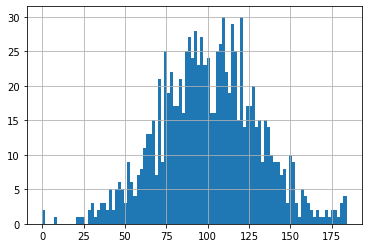

In [501]:
mean = 100
std_dev = 30
df = pd.DataFrame({"Altura": np.clip(np.random.normal(loc=mean, scale=std_dev, size=1000), 0, 210)})
# Datos de ejemplo
df["Altura"].hist(bins=100)
plt.show()

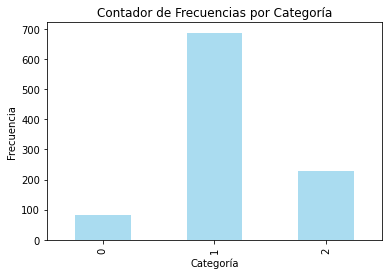

In [502]:
#Divide los datos continuos en intervalos
#'uniform' => igual ancho
#'quantile' => igual cantidad de elementos
#'kmeans' => Basado en cercania'
#encode = {‘onehot’, ‘onehot-dense’, ‘ordinal’},
#subsample=>Maximum number of samples, used to fit the model,
disc = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform', subsample=None)
# Aplicar el binning a los datos
df.loc[:, "Altura"] = disc.fit_transform(df).astype(int)
#df.hist(column="Altura", bins=100)
frq = df['Altura'].value_counts()
frq.sort_index().plot(kind="bar", color='skyblue', alpha=0.7)
plt.title('Contador de Frecuencias por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.show()

Esto puede ser útil para suavizar el ruido,  mejorar la interpretabilidad de los datos o en modelos que requieran datos discretos.

Con inverse_transform podemos volver al dato "real", pero cuidado no al valor anterior sino al valor real agrupado.

In [503]:
df["Altura_recuperada"] = disc.inverse_transform(df[["Altura"]])
np.sort(df["Altura_recuperada"].unique())

array([ 30.66215098,  91.98645295, 153.31075491])

### Duplicados

Para analizar datos algo mas complejos cargamos un dataset sintetico.

In [504]:
df = pd.read_csv("../datasets/synthetic.csv")

¿Tenemos datos duplicados?

In [505]:
print("Cantidad:",  df.duplicated().sum())
df[df.duplicated()].head()


Cantidad: 5


,id,Weight,Heigth,CorrPar01,CorrPar02,CorrTot01,CorrTot02,column90PercentNulls,columnBarValues,columnTwoNulls,SomeNulls,columnOutliers,Salary,ActStatus,date
100000,88104,69.226322,150.799334,-0.273928,-21.055996,1.440683,114.042371,NaN,49.040106,104.438337,117.749759,340.312281,NaN,EMPLEADO,2023-02-03
100001,52364,80.976302,180.188782,-0.803141,-40.831536,-0.901678,-71.375521,NaN,51.807308,112.479476,104.488652,457.512857,947.816159,EMPLEADO,2023-04-09
100002,94725,63.885500,172.952125,-0.597410,-54.147172,0.665158,52.652988,82.138536,50.184573,100.960237,84.059556,1448.085003,NaN,CUENTAPROPISTA,2023-08-23
100003,74576,68.157261,168.886285,0.059369,44.827098,-1.032518,-81.732629,NaN,50.229093,109.346927,100.015719,1130.963717,548.814551,EMPLEADO,2023-10-23
100004,6537,86.045595,154.739006,-0.198607,-27.297896,0.294288,23.295410,NaN,48.312704,81.295609,90.422749,432.290853,NaN,EMPLEADO,2023-10-08


In [506]:
df.loc[df.id==88104]

,id,Weight,Heigth,CorrPar01,CorrPar02,CorrTot01,CorrTot02,column90PercentNulls,columnBarValues,columnTwoNulls,SomeNulls,columnOutliers,Salary,ActStatus,date
88103,88104,69.226322,150.799334,-0.273928,-21.055996,1.440683,114.042371,NaN,49.040106,104.438337,117.749759,340.312281,NaN,EMPLEADO,2023-02-03
100000,88104,69.226322,150.799334,-0.273928,-21.055996,1.440683,114.042371,NaN,49.040106,104.438337,117.749759,340.312281,NaN,EMPLEADO,2023-02-03


Eliminamos los duplicados en línea.

In [507]:
df.drop_duplicates(inplace=True)

¿Hay alguna columna que me permita usarla de índice natural?

In [508]:
df.head()

,id,Weight,Heigth,CorrPar01,CorrPar02,CorrTot01,CorrTot02,column90PercentNulls,columnBarValues,columnTwoNulls,SomeNulls,columnOutliers,Salary,ActStatus,date
0,1,64.184087,168.070999,0.999034,30.903812,-2.260001,-178.898457,NaN,50.998150,100.148133,97.131918,1606.049621,NaN,CUENTAPROPISTA,2023-01-18
1,2,46.126412,181.077266,-0.677798,-95.246768,0.339275,26.856515,NaN,49.420113,94.742504,NaN,1287.601872,1258.474418,CUENTAPROPISTA,2023-12-12
2,3,69.063778,152.707241,-0.231849,5.635023,-0.658232,-52.104707,NaN,50.370909,102.491667,116.824604,1027.802696,515.504684,CUENTAPROPISTA,2023-08-18
3,4,66.387157,167.112693,1.510159,137.983091,0.480864,38.064474,NaN,50.773667,95.569450,118.940471,310.666079,NaN,EMPLEADO,2023-11-28
4,5,51.474388,164.994484,0.104447,31.914088,0.002291,0.181320,NaN,47.119344,101.490901,94.929601,560.070216,531.010266,EMPLEADO,2023-06-30


In [509]:
df.set_index("id", inplace=True)

### Faltantes

¿Tenemos nulos?

In [510]:
df.isna().sum()/df.shape[0]*100

Weight                   0.000
Heigth                   0.000
CorrPar01                0.000
CorrPar02                0.000
CorrTot01                0.000
CorrTot02                0.000
column90PercentNulls    90.000
columnBarValues          0.000
columnTwoNulls           0.002
SomeNulls               10.000
columnOutliers           0.000
Salary                  40.000
ActStatus                5.000
date                     0.000
dtype: float64

Tengo columnas con 90% de nulos y columnas con solo un 0.002% de nulos. La columna "column90PercentNulls" tienen una cantidad muy alta de nulos. Tiendo a pensar en eliminarla o, si presupongo que hay información en los faltantes (Son nulos porque no quisieron contestar entonces puedo crear nueva columna). Si es simplemente mala calidad de datos y con número tan grande me inclino por eliminarla. 

In [511]:
#Elimino la columna con 90% de nulos y las dos filas con nulos.
df.drop(columns=["column90PercentNulls"], inplace=True)

La columna que tiene unicamente 2 valores en nulo, le elimino los valores. Si, estoy perdiendo información, ¿Seria mejor imputarlos? Posiblemente.

In [512]:
#Futuro problema para pensar!
df = df[~df["columnTwoNulls"].isna()]
#Solucion problema =>
#df = df[~df["columnTwoNulls"].isna()].copy()

Decidimos imputar valores a columna somenulls, mas de una forma de hacerlo...

In [513]:
op = 1
if op == 1:
    df.loc[:,["SomeNulls"]].fillna(df["SomeNulls"].mean(), inplace=True)
elif op == 2:
    df.loc[df["SomeNulls"].isna(),["SomeNulls"]] = df["SomeNulls"].mean()
else:
    df.loc[df["SomeNulls"].isna(),["SomeNulls"]] = np.mean(df["SomeNulls"])

Se puede hacer de muchas formas, pero dentro del ecosistema sklearn es recomendable (aunque sea mas burocratico) utilizar las clases sklearn, en el futuro nos ayudará cuando implementemos canalizaciones.

Imputamos "Somenulls" utilizando media. Otras alternativas disponibles "median" y "most_frequent"

In [514]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy="mean")
si.fit(df[["SomeNulls"]])

SimpleImputer()

⚠️Cuidado, error grosero: esta imputación sobre todo el conjunto de datos debe ser tomada como una primera aproximación. Veremos mas adelante una enfoque mas profesional.

In [515]:
si.transform(df[["SomeNulls"]])

array([[ 97.13191759],
       [100.07932149],
       [116.82460444],
       ...,
       [112.86829321],
       [100.07932149],
       [ 88.80120584]])

In [516]:
df.loc[:,"SomeNulls"] = si.transform(df[["SomeNulls"]])

El "ActStatus" es categórico, imputamos con most_frequent

In [517]:
print(df["ActStatus"].unique())

['CUENTAPROPISTA' 'EMPLEADO' nan]


Hago el fit y el transform en una única operación

In [518]:
df.loc[:,"ActStatus"] = SimpleImputer(strategy="most_frequent").fit_transform(df[["ActStatus"]])

Conservo la no respuesta en cuanto a salario.

In [519]:
df["RespondeSalario"] = df["Salary"].isna()

¿Hay un warning? ¿Porque? actualmente df no es mas que una vista del original. Estoy agregando una columna a una vista. ¿Es realmente lo que quiero? - Volver al punto que genera el problema y resolverlo -

¿Podemos usando SimpleImputer imputar la media de todos a los valores superiores a determinado límite?

In [520]:
dfA = pd.DataFrame({"Age": [15,15,16,20,25,25,28,170,180,190,49,50,55,58,58,58,60]})
dfA.loc[dfA["Age"]>160, ["Age"]] = np.nan
si = SimpleImputer(strategy="mean")
si.fit_transform(dfA)

array([[15.],
       [15.],
       [16.],
       [20.],
       [25.],
       [25.],
       [28.],
       [38.],
       [38.],
       [38.],
       [49.],
       [50.],
       [55.],
       [58.],
       [58.],
       [58.],
       [60.]])

La forma de automatizar esto queda para próximas clases.

### Outliers y valores erroneos

In [521]:
df[["Weight", "Heigth"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,99998.0,69.948411,10.004671,22.044648,63.204231,69.964249,76.71097,110.397644
Heigth,99998.0,170.062293,10.002666,129.897125,163.309038,170.044247,176.84812,350.000000


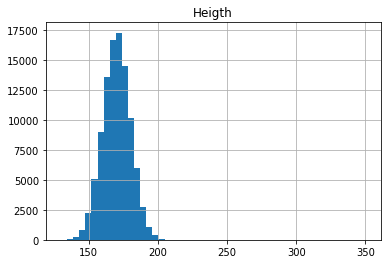

In [522]:
df[["Heigth"]].hist(bins=50)
plt.show()

El boxplot ayuda  descubrir outliers ocultos

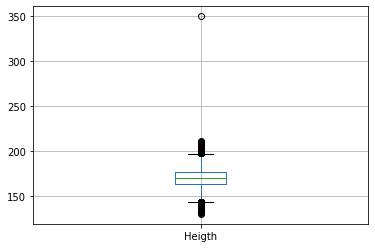

In [523]:
df[["Heigth"]].boxplot()
plt.show()

¿Como funciona el diagrama de cajas?

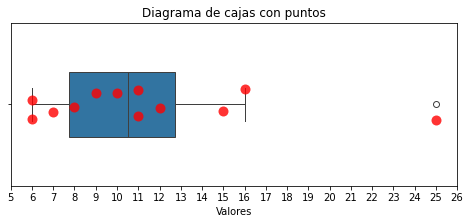

In [524]:
#Random para que dibuje los puntos en iguales posiciones
np.random.seed(42)
data = pd.DataFrame({
    'Valores': [6,6,7,8,9,10,11,11,12,15,16,25],
})

# Crear el diagrama
plt.figure(figsize=(8, 3))
ax = sns.boxplot(x='Valores', data=data, width=0.4, showfliers=True, orient="x")  # Diagrama de cajas
sns.stripplot(x='Valores', data=data, color='red', size=10, alpha=0.8, jitter=True, dodge=True)  # Puntos
# Ajustar detalles del gráfico
plt.title("Diagrama de cajas con puntos")
plt.xticks(range(5,27,1))
plt.show()

Múltiples diagramas de caja (usando sns y puntos)

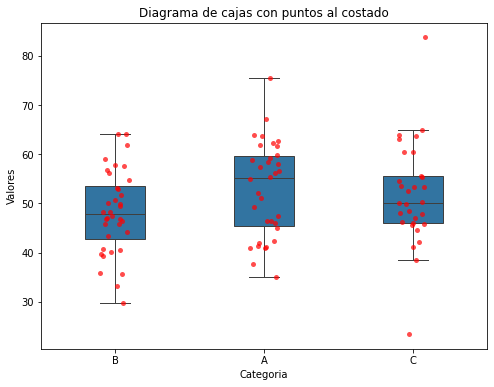

In [525]:
# Crear datos de ejemplo

data = pd.DataFrame({
    'Categoria': np.random.choice(['A', 'B', 'C'], size=100),
    'Valores': np.random.normal(loc=50, scale=10, size=100)
})

# Crear el diagrama
plt.figure(figsize=(8, 6))
sns.boxplot(x='Categoria', y='Valores', data=data, width=0.4, showfliers=False)  # Diagrama de cajas
sns.stripplot(x='Categoria', y='Valores', data=data, color='red', alpha=0.7, jitter=True, dodge=True)  # Puntos

# Ajustar detalles del gráfico
plt.title("Diagrama de cajas con puntos al costado")
plt.show()


Boxplot segun distribuciones

In [526]:
vals_nor_1 = np.random.normal(0, 1, 1000)
vals_nor_2 = np.random.normal(0, 2, 1000)
vals_nor_3 = np.random.normal(0, 4, 1000)

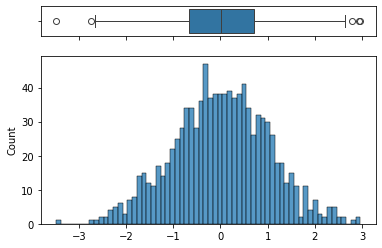

In [527]:
boxplotAndHist(vals_nor_1, binwidth=0.1)

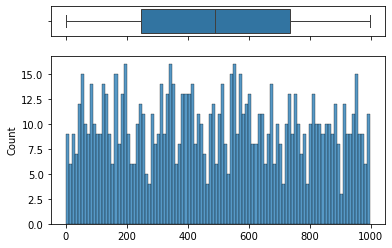

In [528]:
del vals_nor_1, vals_nor_2, vals_nor_3

vals_uni_1 = np.random.uniform(0, 1000, 1000)
boxplotAndHist(vals_uni_1, binwidth=10)

Errores de procesamiento

El histograma puede ayudar a ver la distribucion de los datos, errores de ingreso de datos y dependiendo de la naturaleza de los datos, puede ayudar identificar sesgo

<Axes: >

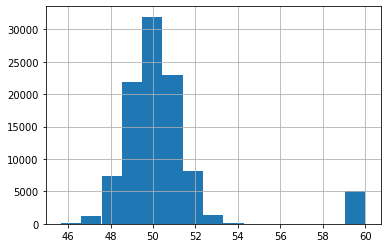

In [529]:
df["columnBarValues"].hist(bins=15)

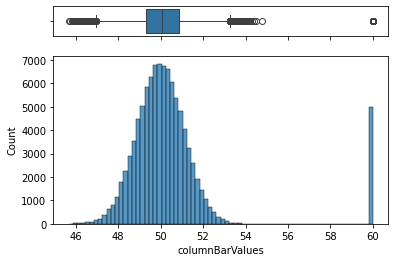

In [530]:
boxplotAndHist(df["columnBarValues"], binwidth=0.2)

Histogramas y lineas de densidad

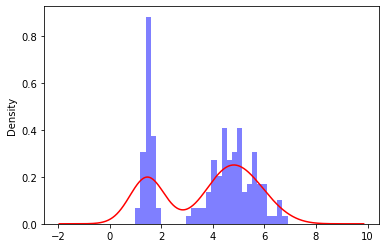

In [531]:
# Cargamos dataset de iris
import pandas as pd
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
skdf = datasets.load_iris(as_frame=False)
df_iris = pd.DataFrame(skdf["data"], columns=skdf['feature_names']) 
target = pd.Series(skdf["target"], name="target")
df_iris = df_iris.join(target)

ax = df_iris["petal length (cm)"].hist(bins=30, density=True, alpha=0.5, color='blue')
df_iris["petal length (cm)"].plot.density(ax=ax, color='red')
plt.show()

## Analisis bivariable

Matriz de correlación. Correlación y Correlación perfecta

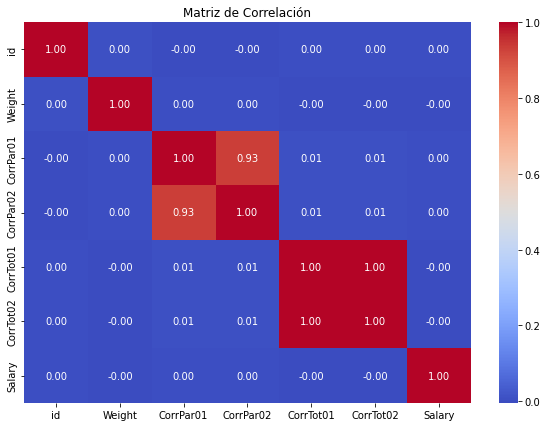

In [533]:
df = pd.read_csv("../datasets/synthetic.csv")
fig, ax = plt.subplots(figsize=(10,7))
mat = df[["id", "Weight", "CorrPar01", "CorrPar02", "CorrTot01", "CorrTot02", "Salary"]].select_dtypes(include=['int', 'float']).corr()
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

Análisis de variables de a pares. Distribuciones y relaciones

<Axes: >

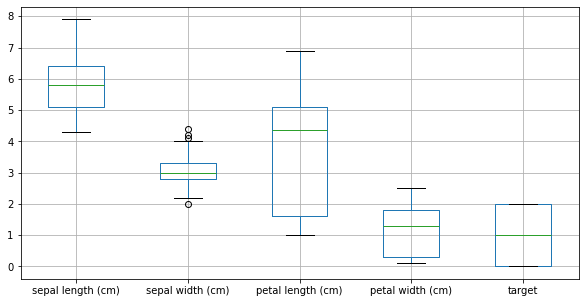

In [534]:
# Asignamos dataset de iris anteriormente cargado
df = df_iris
df.boxplot(return_type='axes', figsize=(10,5))


El diagrama de violines (Seaborn) ademas muestra la distribucion de los datos aunque no es tan bueno para representar outliers

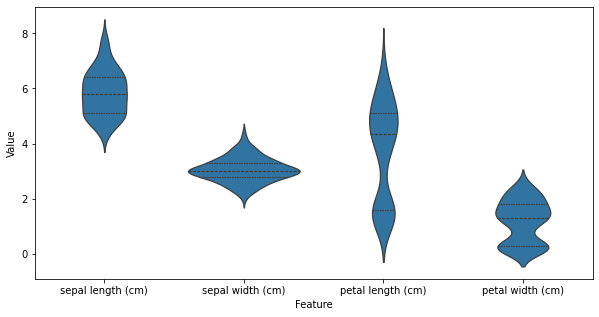

In [535]:
plt.figure(figsize=(10, 5))
df_melted = pd.melt(df, id_vars="target", var_name="Feature", value_name="Value")
ax = sns.violinplot(x="Feature", y="Value", data=df_melted,  inner="quart")
plt.show()

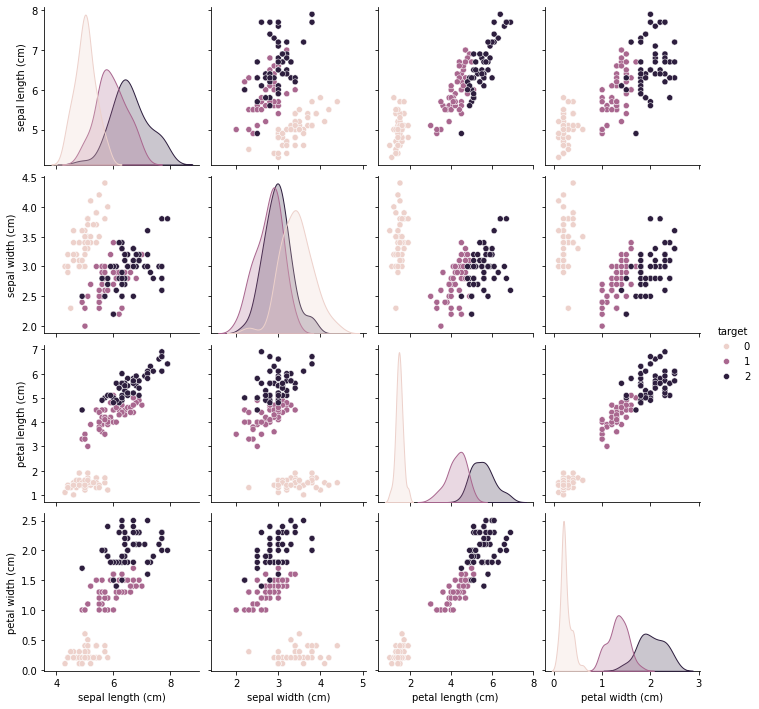

In [536]:
sns.pairplot(df, hue="target")

In [537]:
df = pd.read_csv("../datasets/titanic.csv")


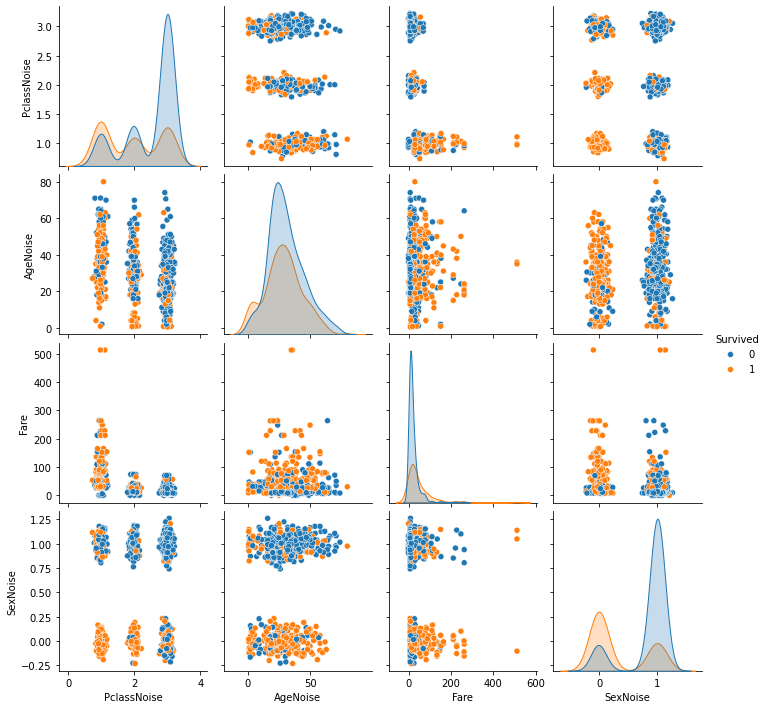

In [538]:
#Meto algo de ruido en pclass para obtener numeros floatantes que me permita ver
#densidad
df["Sex"] = df["Sex"].map({"male": 1, "female": 0})
df["PclassNoise"] = df["Pclass"]+np.random.normal(0, 0.08, df.shape[0]) 
df["AgeNoise"] = df["Age"]+np.random.normal(0, 0.08, df.shape[0])
df["SexNoise"] = df["Sex"]+np.random.normal(0, 0.08, df.shape[0])
sns.pairplot(df[["PclassNoise", "AgeNoise", "Survived", "Fare", "SexNoise"]], hue="Survived")
plt.show()

Datos categóricos, diagrama de barras

In [539]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'PclassNoise',
       'AgeNoise', 'SexNoise'],
      dtype='object')

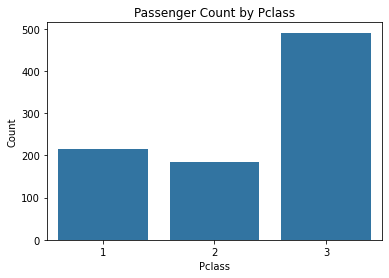

In [540]:
sns.countplot(x='Pclass', data=df)
plt.title('Passenger Count by Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

## Análisis multivariables.

Clasificación 

Visualizacion de la clase target y su relación con las predictoras

In [ ]:
df = pd.read_csv('../datasets/Default.csv')
plt.figure(figsize=(10, 5))
plt.scatter(df['balance'],
            df['income'], c=df['default'].map({'No': 'blue', 'Yes': 'red'}), 
            marker='x', alpha=0.5)
plt.xlabel('Balance')
plt.ylabel('Income')
plt.title('Balance vs Income')
plt.show()

-------

¿Como resuelvo cuando al densidad de los datos no me permite visualizar?

Diagrama de agrupación hexagonal

Permite ver la densidad cuando la cantidad de datos es demasiado grande y el scatter plot se muestra una nube de dificil interpretación.

In [ ]:
df = pd.read_csv("../datasets/kc_tax.csv.gz")
dfFlt = df.loc[(df.TaxAssessedValue < 750000) & 
                     (df.SqFtTotLiving > 100) &
                     (df.SqFtTotLiving < 3500), :]

In [ ]:
plt.plot(dfFlt.SqFtTotLiving, dfFlt.TaxAssessedValue, 'o', alpha=0.1)
plt.tight_layout()
plt.show()

In [ ]:
ax = dfFlt.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',cmap='inferno', gridsize=30, figsize=(10, 7))
ax.set_xlabel('Superficie cubierta')
ax.set_ylabel('Valuacion fiscal')

plt.tight_layout()
plt.show()

# Ingeniería de características (Intro)

## Columna IMC.
Agregamos una nueva columna manualmente. En este caso se información que el "experto" considera razonable para la mejora del modelo. Veremos en el futuro el agregado como la eliminacion de las columnas por métodos automáticos.

In [ ]:
df = pd.read_csv("../datasets/alturas-pesos.csv")
df.loc[:, "IMC"] = df["Peso"]/(df["Altura"]/100)**2
df

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,7))
mat = df.select_dtypes(include=['int', 'float']).corr()
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
plt.scatter(df["Peso"], df["IMC"])
plt.scatter(df["Altura"], df["IMC"])